In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
mpl.rcParams['figure.dpi']= 200
mpl.rc("savefig", dpi=200)
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False
from datetime import date

In [2]:
enterprise_info = pd.read_csv('data/1_info.csv')
enterprise_info

,企业代号,企业名称,信誉评级,是否违约
0,E1,***电器销售有限公司,A,否
1,E2,***技术有限责任公司,A,否
2,E3,***电子(中国)有限公司***分公司,C,否
3,E4,***发展有限责任公司,C,否
4,E5,***供应链管理有限公司,B,否
...,...,...,...,...
118,E119,***药房,D,是
119,E120,***陈列广告有限公司,D,是
120,E121,***药业连锁有限公司***药店,D,是
121,E122,***商贸有限责任公司,D,是


In [3]:
enterprise_reputation = {}
for i, row in enterprise_info.iterrows():
    enterprise_reputation[row['企业代号']] = row['信誉评级']
# enterprise_reputation

In [4]:
status_to_int = {
    '有效发票': 0,
    '作废发票': 1,
}

def preprocess(df: pd.DataFrame):
    df['date'] = pd.to_datetime(df['开票日期'])
    df['status'] = df['发票状态'].map(status_to_int).astype(np.int)
    df.drop(['开票日期', '发票状态'], axis=1, inplace=True)
    return df


invoice_in = preprocess(pd.read_csv('data/1_in.csv'))
invoice_out = preprocess(pd.read_csv('data/1_out.csv'))

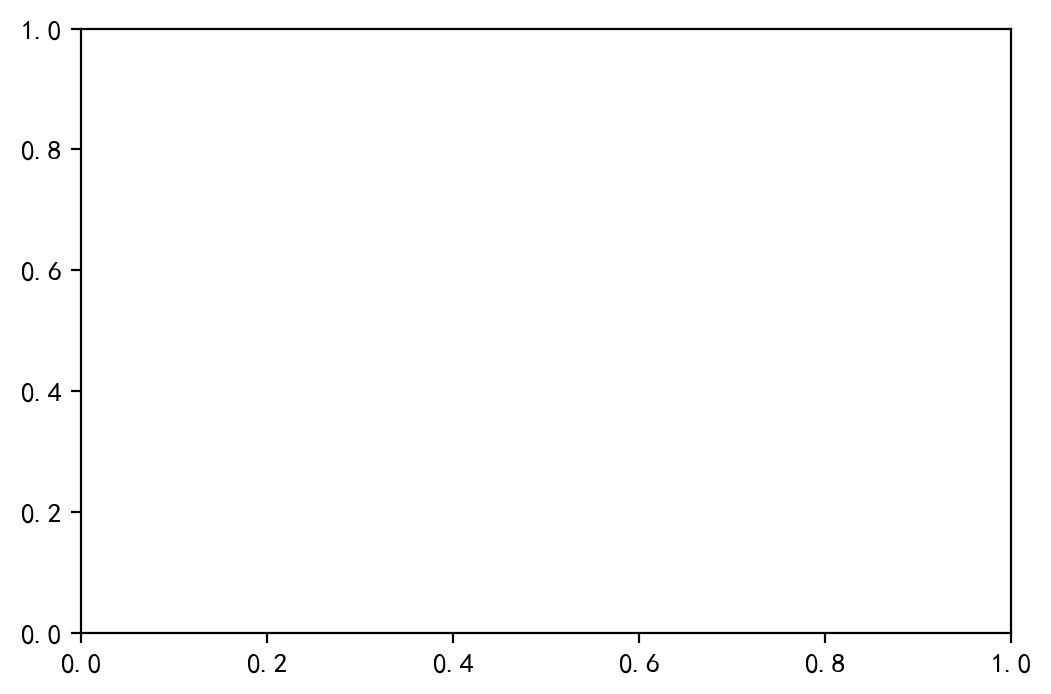

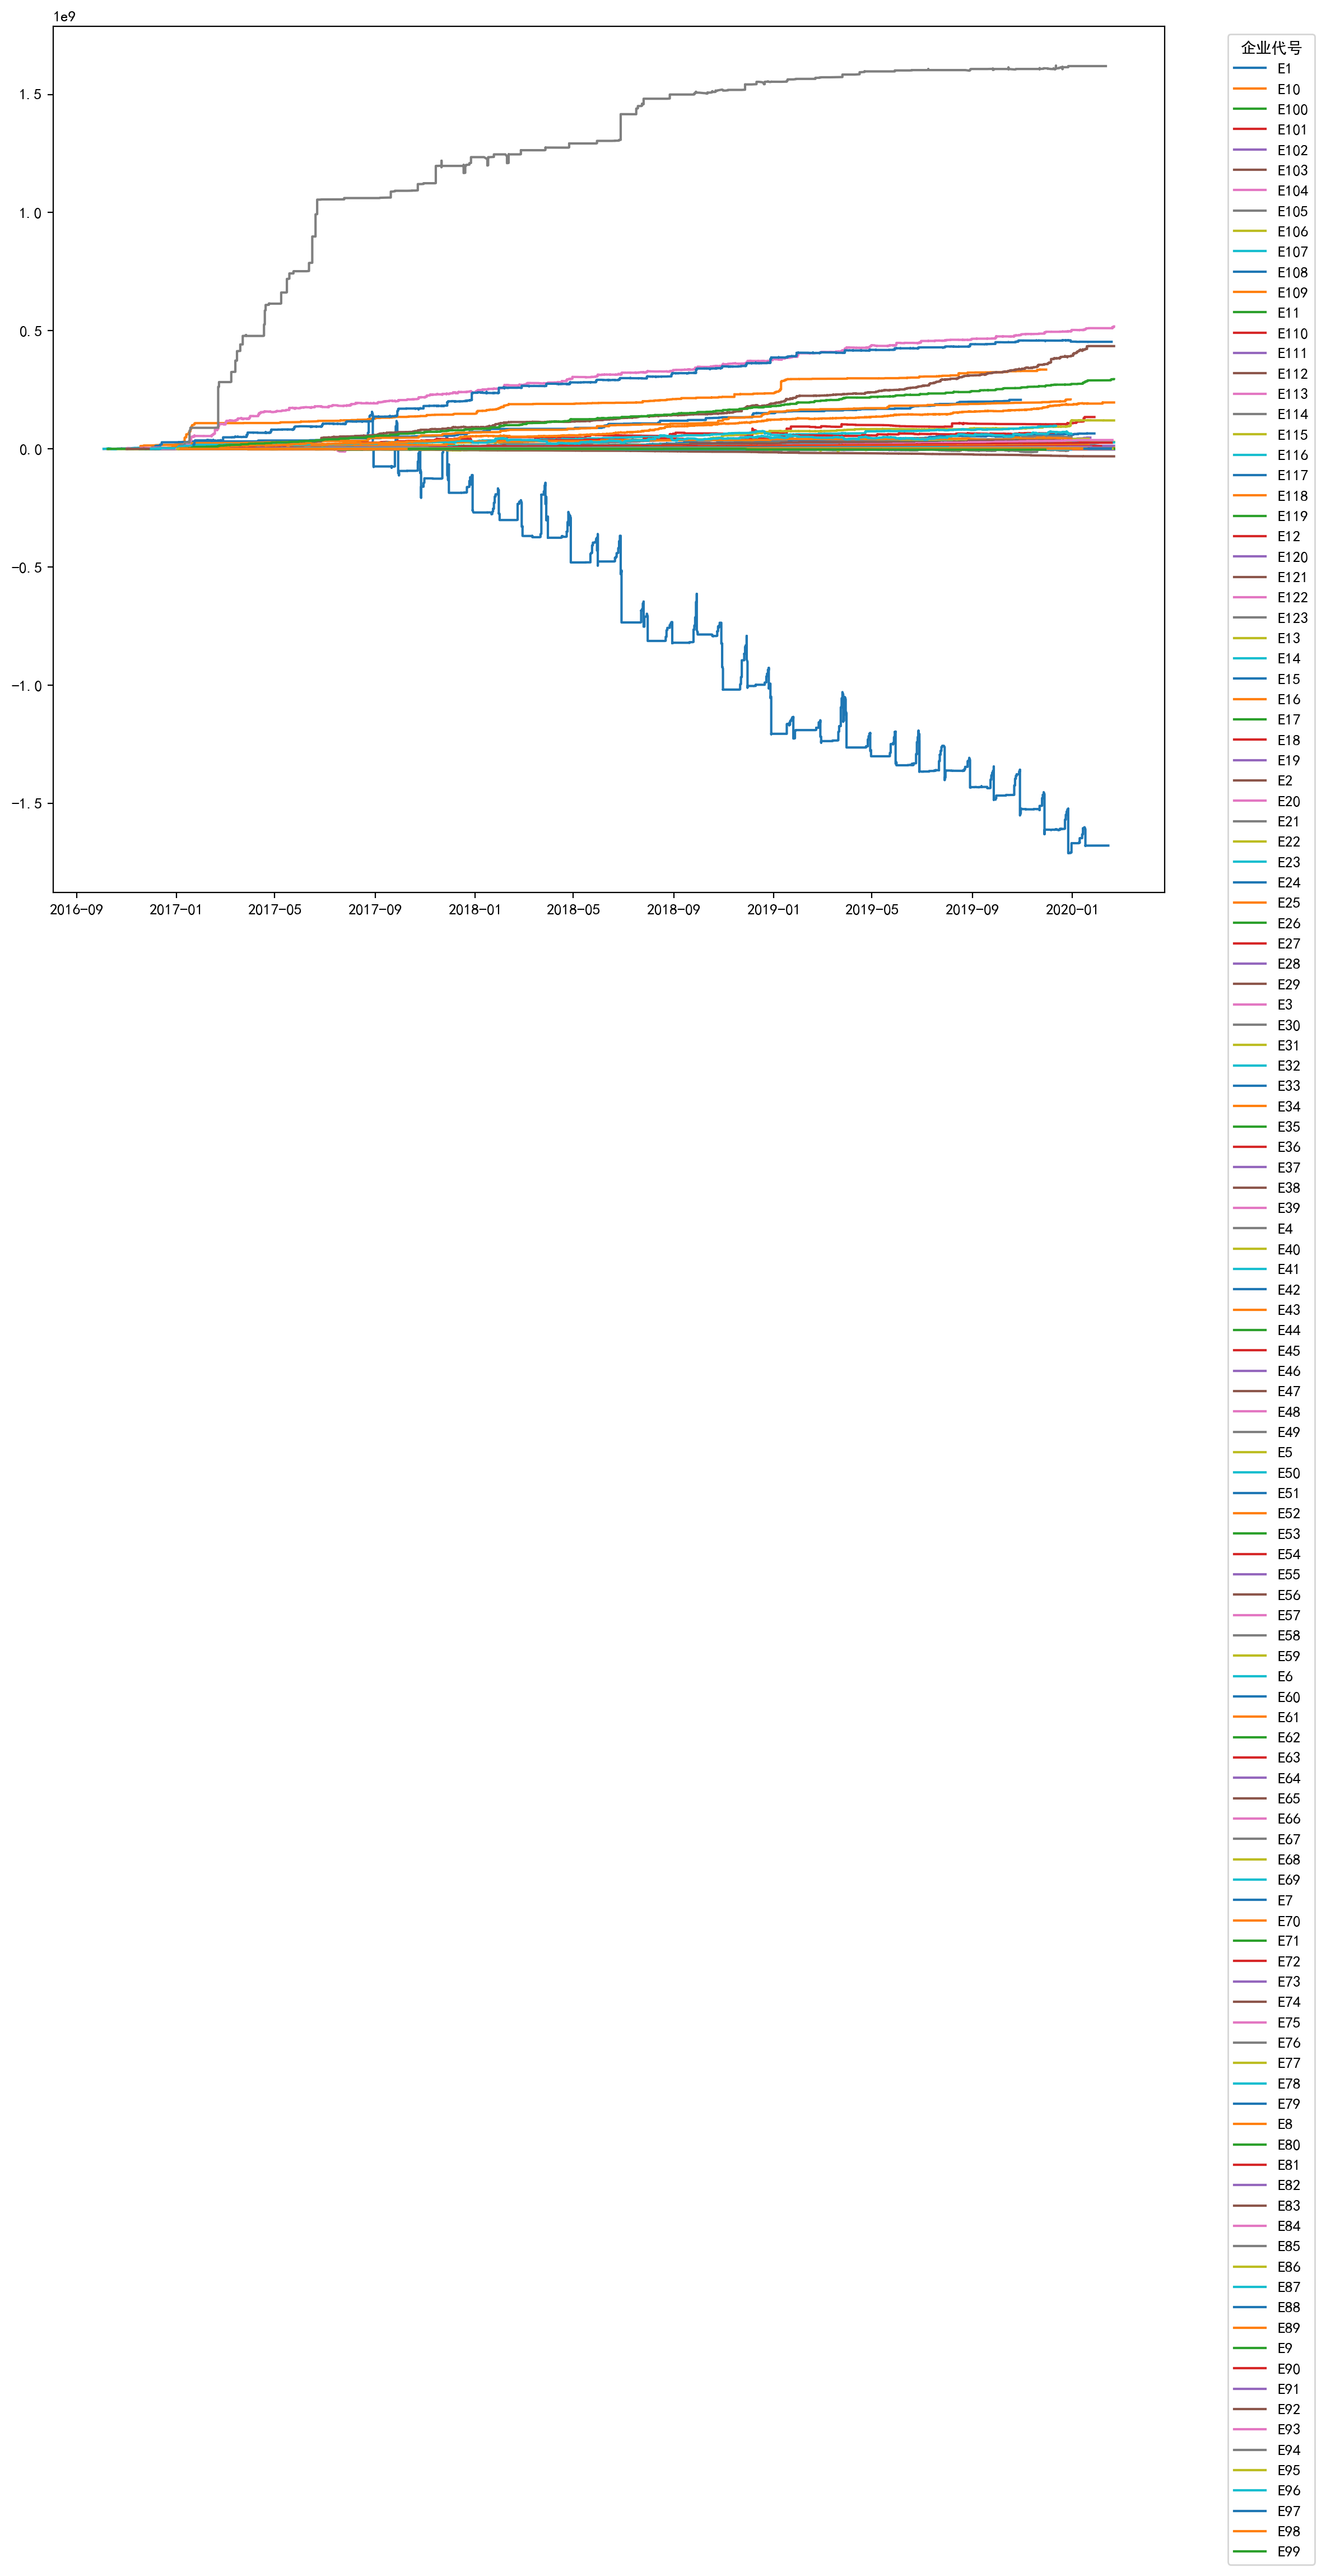

In [28]:
cost = invoice_in[invoice_in['status'] == 0][['企业代号', '金额', 'date']]
income = invoice_out[invoice_out['status'] == 0][['企业代号', '金额', 'date']]
cost['金额'] = -invoice_in['金额']

df = pd.concat([cost, income])
df = df.sort_values('date')
ax = plt.subplot()
groups = df.groupby('企业代号')
legend_handles = []
plt.figure(figsize=(12.80, 10.24))
for name, data in groups:
    hdl, = plt.plot(data['date'], data['金额'].cumsum(), label=name)
    legend_handles.append(hdl)
plt.legend(handles=legend_handles, title='企业代号', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.savefig('deposit.png')


# Find percentage of invalid invoice

In [6]:
def invalid_percent(df: pd.DataFrame):
    df = df.groupby(['企业代号', 'status'])['金额'].agg(['count'])
    df = df.groupby(level=0).apply(lambda x: x / x.sum())
    df = df.reset_index()
    df = df[df['status'] == 1]
    df['reputation'] = df['企业代号'].map(enterprise_reputation)
    df = df.sort_values('count', ascending=False)
    return df


invalid_invoice_in = invalid_percent(invoice_in)
invalid_invoice_out = invalid_percent(invoice_out)
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(invalid_invoice_in)
    print(invalid_invoice_in.shape)
    print('=' * 30)
    print(invalid_invoice_out)
    print(invalid_invoice_out.shape)

     企业代号  status     count reputation
108   E43       1  0.128205          B
87    E33       1  0.123743          B
89    E34       1  0.103075          B
27   E114       1  0.092105          D
134   E55       1  0.086270          C
59    E20       1  0.078761          B
46    E14       1  0.077717          C
75    E28       1  0.076923          B
61    E21       1  0.071799          B
32   E118       1  0.068966          D
101    E4       1  0.066308          C
191   E83       1  0.066090          B
138   E57       1  0.061538          B
3     E10       1  0.057847          B
51    E17       1  0.056158          A
63    E22       1  0.055901          A
124   E50       1  0.055838          C
1      E1       1  0.055798          A
132   E54       1  0.054136          A
91    E35       1  0.053812          B
53    E18       1  0.053773          A
208   E91       1  0.050847          A
21   E111       1  0.050360          D
130   E53       1  0.049206          C
144    E6       1  0.0461

# Find tax-free transactions

In [7]:
def tax_free_percentage(df: pd.DataFrame):
    def tf_percent(x):
        percent = x[x['税额'] == 0]['金额'].sum() / x['金额'].sum()
        return pd.Series({'tax_free': percent})

    df = df.groupby('企业代号')[['金额', '税额']].apply(tf_percent)
    df = df.reset_index()
    df['reputation'] = df['企业代号'].map(enterprise_reputation)
    df = df.sort_values('tax_free', ascending=False)
    return df


tax_free_in = tax_free_percentage(invoice_in)
tax_free_out = tax_free_percentage(invoice_out)
with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'precision', 3):
    print(tax_free_in)
    print(tax_free_in.shape)
    print('=' * 30)
    print(tax_free_out)
    print(tax_free_out.shape)

     企业代号   tax_free reputation
95    E74  9.780e-01          B
92    E71  8.165e-01          B
50    E33  4.000e-01          B
96    E75  2.111e-01          C
101    E8  2.021e-01          A
115   E92  1.940e-01          C
73    E54  1.657e-01          A
49    E32  1.606e-01          B
74    E55  1.346e-01          C
59    E41  1.226e-01          C
109   E87  1.116e-01          C
58    E40  9.727e-02          C
80    E60  9.060e-02          B
8    E106  8.140e-02          B
1     E10  8.045e-02          B
24   E120  7.193e-02          D
55    E38  6.832e-02          B
48    E31  6.790e-02          A
112    E9  6.398e-02          A
116   E93  6.283e-02          B
35     E2  6.119e-02          A
90     E7  6.021e-02          A
105   E83  5.158e-02          B
41    E25  4.149e-02          C
91    E70  4.003e-02          B
5    E103  3.763e-02          D
46     E3  3.592e-02          C
10   E108  2.922e-02          D
17   E114  2.688e-02          D
97    E76  2.419e-02          B
114   E9